In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os, glob, random, itertools
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [ ]:

# ---------------------------------------------------------
# 1. Paths & constants
# ---------------------------------------------------------
DATASET_DIR = "/content/drive/MyDrive/ChestXRay2017/chest_xray"   # <-- change if needed
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
AUTOTUNE    = tf.data.AUTOTUNE

# ---------------------------------------------------------
# 2. Build a DataFrame of filepaths + clean labels
# ---------------------------------------------------------
def subclass_from_filename(fname: str) -> str:
    """Return 'bacterial', 'viral', or generic 'pneumonia'."""
    lower = fname.lower()
    if "_bacteria" in lower: return "bacterial"
    if "_virus"    in lower: return "viral"
    return "pneumonia"                 # fallback

records = []
for split in ("train", "test"):
    for cls in ("NORMAL", "PNEUMONIA"):
        folder = os.path.join(DATASET_DIR, split, cls)
        for fp in glob.glob(os.path.join(folder, "*.jpeg")):
            label = "normal" if cls == "NORMAL" else subclass_from_filename(fp)
            records.append((fp, label, split))

df = pd.DataFrame(records, columns=["filepath", "label", "split"])
print("Total images:", len(df))
df.head()


Total images: 5876


,filepath,label,split
0,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train
1,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train
2,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train
3,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train
4,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train


In [ ]:
# ---------------------------------------------------------
# 3. Create a validation split
# ---------------------------------------------------------
from sklearn.model_selection import train_test_split

train_df = df[df.split=="train"]
train_idx, val_idx = train_test_split(
    train_df.index,
    test_size=0.15,
    stratify=train_df["label"],
    random_state=42)

df.loc[val_idx, "split"] = "val"
print(df["split"].value_counts())


split
train    4464
val       788
test      624
Name: count, dtype: int64


# **Exploratory Data Analysis**

## **Class distribution by split**

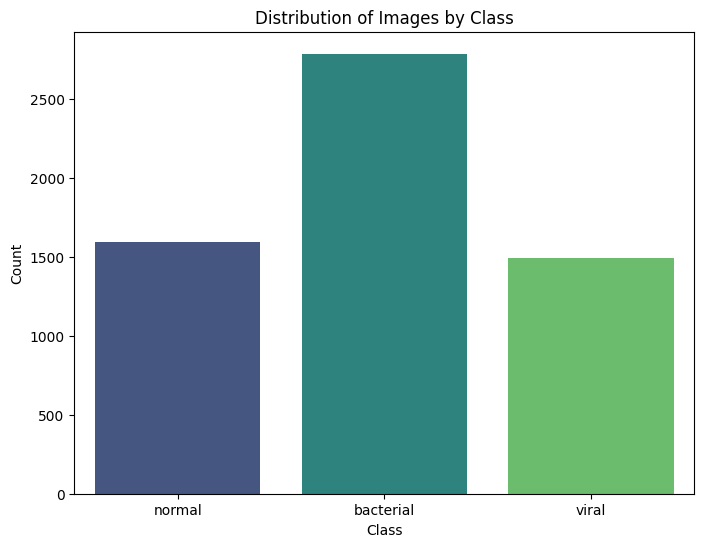

In [ ]:
# Class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="label", data=df, palette="viridis", hue="label", legend=False)
plt.title("Distribution of Images by Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

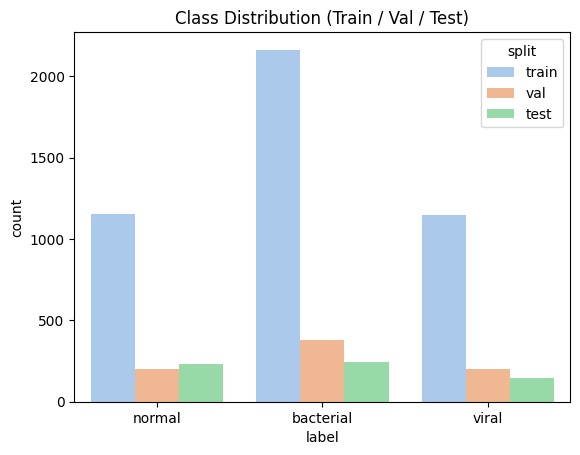

In [ ]:
#   Class distribution by split
sns.countplot(x="label", hue="split", data=df, palette="pastel")
plt.title("Class Distribution (Train / Val / Test)")
plt.show()

## **Random image mosaics for sanity-check**

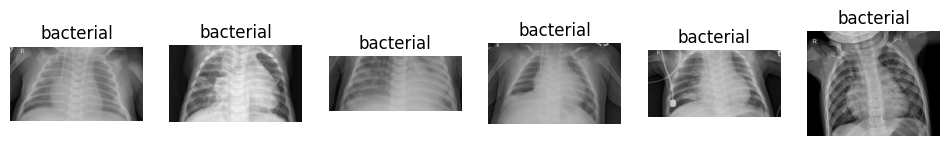

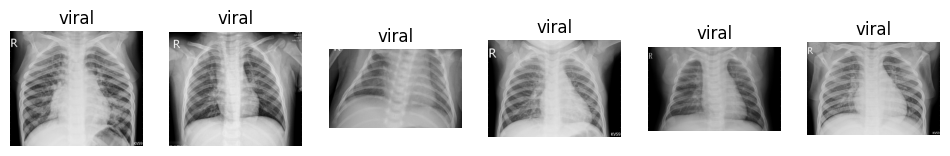

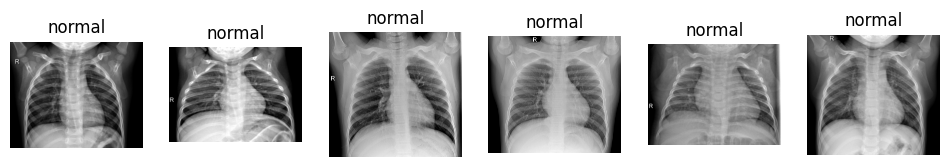

In [ ]:
# Random image mosaics for sanity-check
def show_random_samples(lbl="bacterial", n=6):
    sample_paths = df[(df.label==lbl) & (df.split=="train")]["filepath"].sample(n)
    plt.figure(figsize=(12,2))
    for i, fp in enumerate(sample_paths, 1):
        img = plt.imread(fp)
        plt.subplot(1, n, i)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(lbl)
    plt.show()

for lbl in ["bacterial", "viral", "normal"]:
    show_random_samples(lbl)

In [ ]:


#  Image-size statistics
shapes = [tf.image.decode_jpeg(tf.io.read_file(fp), channels=3).shape
          for fp in tqdm(df["filepath"])]
shape_df = pd.DataFrame(shapes, columns=["h","w","c"])
print(shape_df.describe()[["h","w"]])


  0%|          | 0/5876 [00:00<?, ?it/s]

                h            w
count  5876.00000  5876.000000
mean    970.44418  1327.361811
std     383.36124   363.491567
min     127.00000   384.000000
25%     688.00000  1056.000000
50%     887.00000  1280.000000
75%    1187.00000  1560.000000
max    2713.00000  2916.000000


# **Preprocessing**

In [ ]:

#  list of filepaths & labels → tf.data.Dataset
label_to_index = {lbl:i for i,lbl in enumerate(sorted(df["label"].unique()))}

def paths_to_dataset(filepaths, labels):
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    # -- map strings → image tensors + one-hot labels
    def _load(path, lbl):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0         # [0,1]
        lbl = tf.one_hot(lbl, depth=len(label_to_index))
        return img, lbl
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    return ds

# Gather splits
train_paths = df[df.split=="train"]["filepath"].tolist()
train_labels= df[df.split=="train"]["label"].map(label_to_index).tolist()

val_paths   = df[df.split=="val"]["filepath"].tolist()
val_labels  = df[df.split=="val"]["label"].map(label_to_index).tolist()

test_paths  = df[df.split=="test"]["filepath"].tolist()
test_labels = df[df.split=="test"]["label"].map(label_to_index).tolist()

# Build datasets
train_ds = paths_to_dataset(train_paths, train_labels)\
             .shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds   = paths_to_dataset(val_paths, val_labels)\
             .batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds  = paths_to_dataset(test_paths, test_labels)\
             .batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Dataset shapes →", next(iter(train_ds))[0].shape, next(iter(train_ds))[1].shape)


Dataset shapes → (32, 224, 224, 3) (32, 3)


# **Model Implementation**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

# Dataset-specific values
NUM_CLASSES = 3
EPOCHS = 15
INPUT_SHAPE = (224, 224, 3)
class_names = sorted(label_to_index.keys())

We Build Four models
The four models include:

- DenseNet121 (Transfer Learning)

- Custom CNN (lightweight from scratch)

- MobileNetV2 (Transfer Learning)

- VGG16 (Transfer Learning)

In [ ]:

# ----------------------------------------------------------------
# 1. DenseNet121 Model
# ----------------------------------------------------------------
def build_densenet_model(num_classes):
    base = tf.keras.applications.DenseNet121(
        include_top=False, weights="imagenet",
        input_shape=INPUT_SHAPE, pooling="avg")
    base.trainable = False
    inputs = layers.Input(shape=INPUT_SHAPE)
    x = base(inputs, training=False)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ----------------------------------------------------------------
# 2. Custom CNN Model
# ----------------------------------------------------------------
def build_custom_cnn(num_classes):
    inputs = layers.Input(shape=INPUT_SHAPE)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ----------------------------------------------------------------
# 3. MobileNetV2 Model
# ----------------------------------------------------------------
def build_mobilenet_model(num_classes):
    base = tf.keras.applications.MobileNetV2(
        include_top=False, weights="imagenet",
        input_shape=INPUT_SHAPE, pooling="avg")
    base.trainable = False
    inputs = layers.Input(shape=INPUT_SHAPE)
    x = base(inputs, training=False)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ----------------------------------------------------------------
# 4. VGG16 Model
# ----------------------------------------------------------------
def build_vgg16_model(num_classes):
    base = tf.keras.applications.VGG16(
        include_top=False, weights="imagenet",
        input_shape=INPUT_SHAPE, pooling="avg")
    base.trainable = False
    inputs = layers.Input(shape=INPUT_SHAPE)
    x = base(inputs, training=False)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

In [ ]:
# Add data augmentation to the training dataset
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

Train and Evalute the model


 Training DenseNet121...
Epoch 1/10
140/140 - 393s - 3s/step - accuracy: 0.6723 - auc: 0.8378 - loss: 0.8198 - precision: 0.6914 - recall: 0.6398 - val_accuracy: 0.5926 - val_auc: 0.7468 - val_loss: 1.0084 - val_precision: 0.6207 - val_recall: 0.5546
Epoch 2/10
140/140 - 134s - 959ms/step - accuracy: 0.6940 - auc: 0.8506 - loss: 0.7869 - precision: 0.7208 - recall: 0.6557 - val_accuracy: 0.7500 - val_auc: 0.9038 - val_loss: 0.6032 - val_precision: 0.8006 - val_recall: 0.7132
Epoch 3/10
140/140 - 146s - 1s/step - accuracy: 0.7128 - auc: 0.8647 - loss: 0.7587 - precision: 0.7429 - recall: 0.6783 - val_accuracy: 0.6967 - val_auc: 0.8804 - val_loss: 0.6683 - val_precision: 0.7237 - val_recall: 0.6713
Epoch 4/10
140/140 - 91s - 651ms/step - accuracy: 0.7211 - auc: 0.8731 - loss: 0.7238 - precision: 0.7505 - recall: 0.6705 - val_accuracy: 0.7614 - val_auc: 0.9161 - val_loss: 0.5650 - val_precision: 0.7976 - val_recall: 0.7449
Epoch 5/10
140/140 - 90s - 646ms/step - accuracy: 0.7159 - auc: 0

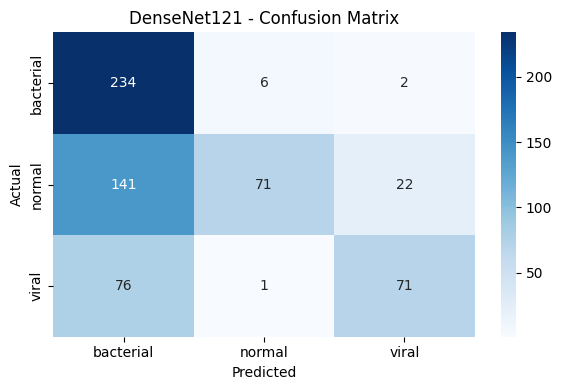

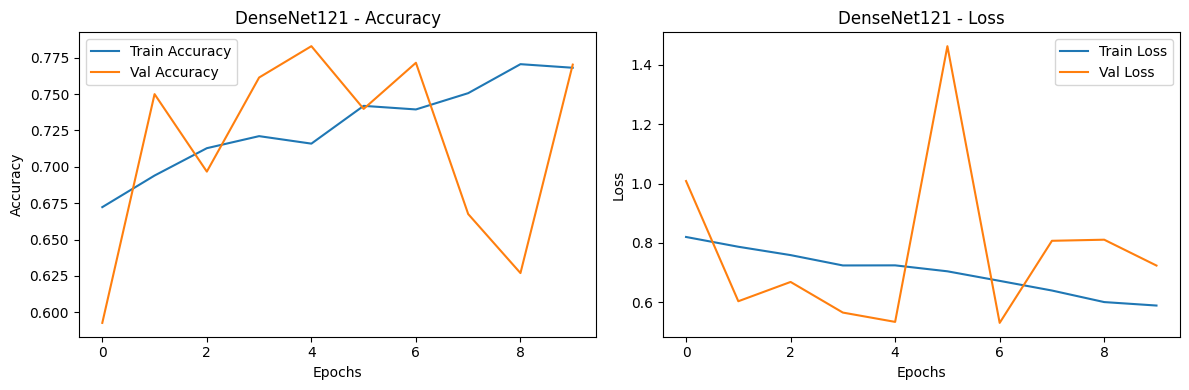


 Training Custom CNN...
Epoch 1/10
140/140 - 91s - 649ms/step - accuracy: 0.4996 - auc: 0.6544 - loss: 1.0316 - precision: 0.5348 - recall: 0.1653 - val_accuracy: 0.4848 - val_auc: 0.5939 - val_loss: 1.2273 - val_precision: 0.4848 - val_recall: 0.4848
Epoch 2/10
140/140 - 135s - 962ms/step - accuracy: 0.4845 - auc: 0.5706 - loss: 1.1364 - precision: 0.4017 - recall: 0.0939 - val_accuracy: 0.4848 - val_auc: 0.5968 - val_loss: 1.0770 - val_precision: 0.4830 - val_recall: 0.4683
Epoch 3/10
140/140 - 77s - 549ms/step - accuracy: 0.4848 - auc: 0.5831 - loss: 1.0790 - precision: 0.4165 - recall: 0.0995 - val_accuracy: 0.4848 - val_auc: 0.6092 - val_loss: 1.0618 - val_precision: 0.4802 - val_recall: 0.4302
Epoch 4/10
140/140 - 86s - 618ms/step - accuracy: 0.4859 - auc: 0.6103 - loss: 1.0622 - precision: 0.5076 - recall: 0.1194 - val_accuracy: 0.4860 - val_auc: 0.6298 - val_loss: 1.0501 - val_precision: 0.5137 - val_recall: 0.4036
Epoch 5/10
140/140 - 80s - 571ms/step - accuracy: 0.4917 - auc

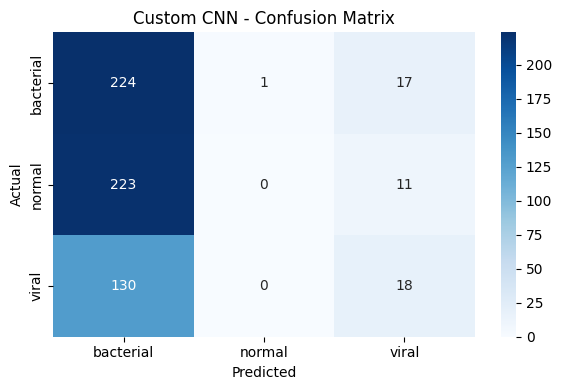

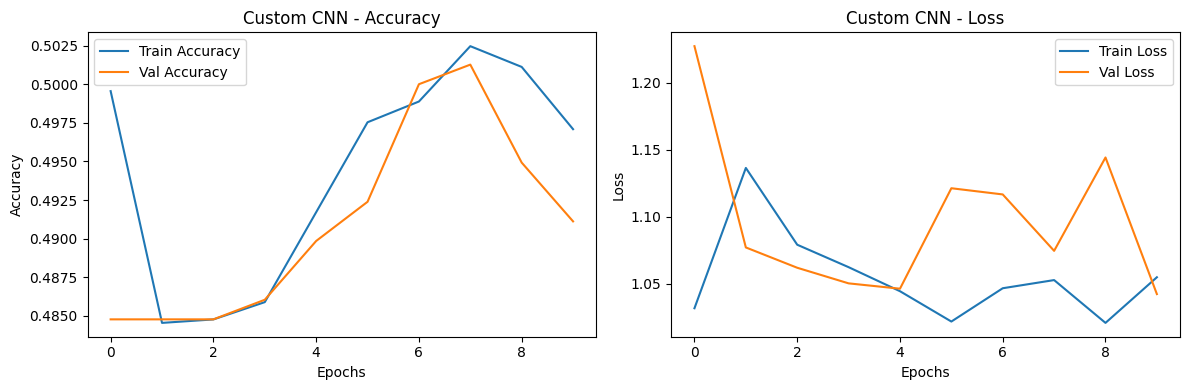


 Training MobileNetV2...
Epoch 1/10
140/140 - 162s - 1s/step - accuracy: 0.7186 - auc: 0.8847 - loss: 0.6425 - precision: 0.7408 - recall: 0.6850 - val_accuracy: 0.2805 - val_auc: 0.6209 - val_loss: 1.4681 - val_precision: 0.2782 - val_recall: 0.2754
Epoch 2/10
140/140 - 81s - 579ms/step - accuracy: 0.7168 - auc: 0.8640 - loss: 0.7766 - precision: 0.7378 - recall: 0.6853 - val_accuracy: 0.4962 - val_auc: 0.6116 - val_loss: 1.4471 - val_precision: 0.5007 - val_recall: 0.4543
Epoch 3/10
140/140 - 79s - 562ms/step - accuracy: 0.7164 - auc: 0.8736 - loss: 0.7091 - precision: 0.7455 - recall: 0.6806 - val_accuracy: 0.5292 - val_auc: 0.6649 - val_loss: 1.8681 - val_precision: 0.5287 - val_recall: 0.5266
Epoch 4/10
140/140 - 85s - 610ms/step - accuracy: 0.7256 - auc: 0.8677 - loss: 0.7371 - precision: 0.7697 - recall: 0.6602 - val_accuracy: 0.5660 - val_auc: 0.7142 - val_loss: 1.4189 - val_precision: 0.5689 - val_recall: 0.5660
Epoch 5/10
140/140 - 84s - 600ms/step - accuracy: 0.7272 - auc: 

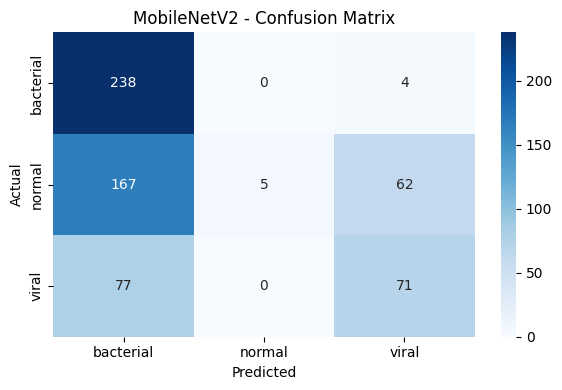

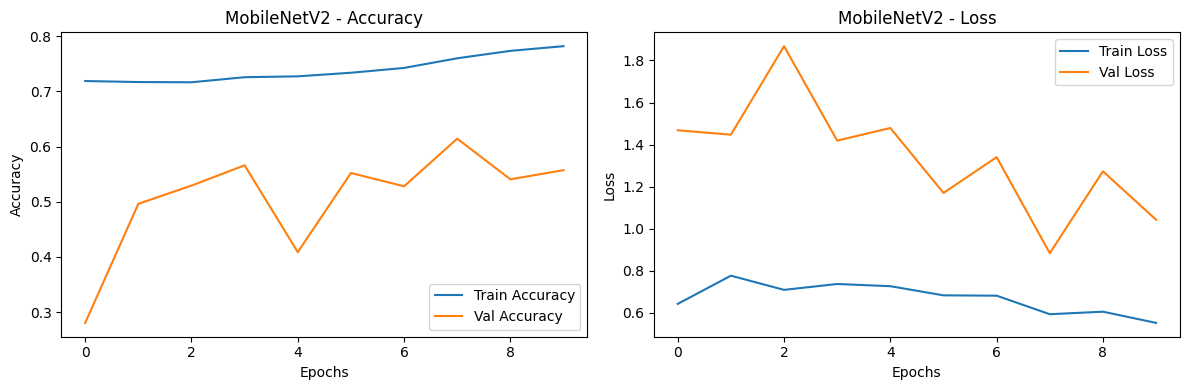


 Training VGG16...
Epoch 1/10
140/140 - 203s - 1s/step - accuracy: 0.6102 - auc: 0.8015 - loss: 0.8395 - precision: 0.6545 - recall: 0.5101 - val_accuracy: 0.6206 - val_auc: 0.8152 - val_loss: 0.8249 - val_precision: 0.7519 - val_recall: 0.3731
Epoch 2/10
140/140 - 102s - 730ms/step - accuracy: 0.6187 - auc: 0.8121 - loss: 0.8089 - precision: 0.6538 - recall: 0.5500 - val_accuracy: 0.4848 - val_auc: 0.7119 - val_loss: 0.9815 - val_precision: 0.5703 - val_recall: 0.4734
Epoch 3/10
140/140 - 142s - 1s/step - accuracy: 0.5856 - auc: 0.7908 - loss: 0.8394 - precision: 0.6602 - recall: 0.4727 - val_accuracy: 0.6599 - val_auc: 0.8289 - val_loss: 0.7804 - val_precision: 0.7443 - val_recall: 0.4543
Epoch 4/10
140/140 - 144s - 1s/step - accuracy: 0.6286 - auc: 0.8209 - loss: 0.7901 - precision: 0.7069 - recall: 0.5083 - val_accuracy: 0.5622 - val_auc: 0.7740 - val_loss: 0.9028 - val_precision: 0.6442 - val_recall: 0.4734
Epoch 5/10
140/140 - 141s - 1s/step - accuracy: 0.6203 - auc: 0.8182 - lo

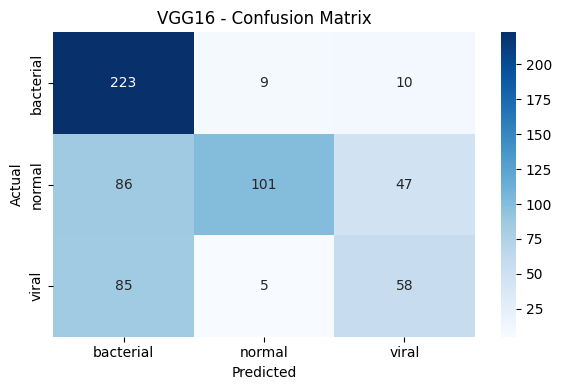

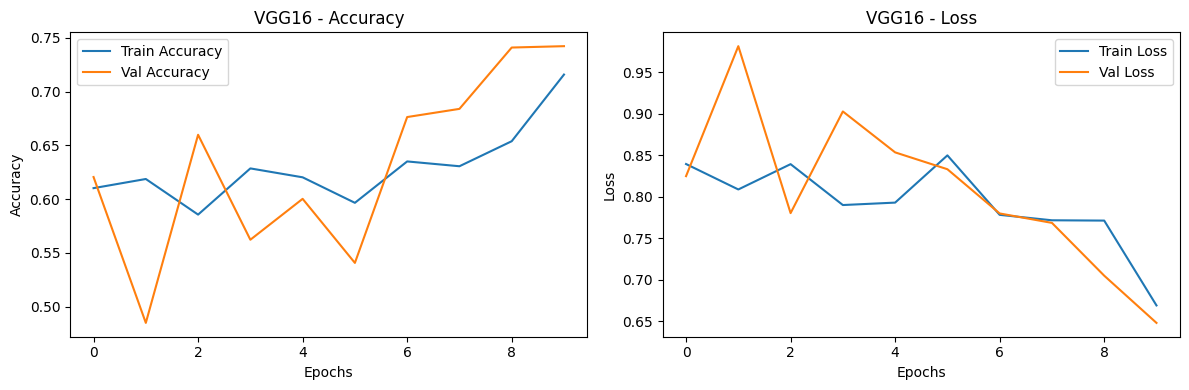

In [ ]:
# Compile and train
def compile_and_train(model, name, train_ds, val_ds, epochs=EPOCHS):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    print(f"\n Training {name}...")
    start_time = time.time()


    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f'{name}_best_model.keras', monitor='val_loss', save_best_only=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=2,
        callbacks=[model_checkpoint]

    )
    train_time = time.time() - start_time
    print(f" Training time for {name}: {train_time:.2f} seconds")
    return model, history, train_time

# Train and evaluate all models
models_to_train = {
    "DenseNet121": build_densenet_model(NUM_CLASSES),
    "Custom CNN": build_custom_cnn(NUM_CLASSES),
    "MobileNetV2": build_mobilenet_model(NUM_CLASSES),
    "VGG16": build_vgg16_model(NUM_CLASSES)
}

model_histories = {}

# Reduce epochs for initial testing
EPOCHS = 10

for model_name, model_instance in models_to_train.items():
    # Fine-tune pre-trained models (unfreeze some layers)
    if model_name in ["DenseNet121", "MobileNetV2", "VGG16"]:
        model_instance.trainable = True
        # Unfreeze the last few layers (adjust as needed)
        for layer in model_instance.layers[-30:]:
            layer.trainable = True

    model, history, train_time = compile_and_train(model_instance, model_name, train_ds, val_ds, epochs=EPOCHS)

    # Evaluation
    print(f"\n Evaluating {model_name}...")
    start_test = time.time()
    y_true, y_pred = [], []

    # Load the best model saved by ModelCheckpoint for evaluation
    best_model = tf.keras.models.load_model(f'{model_name}_best_model.keras')


    for x_batch, y_batch in test_ds:
        preds = best_model.predict(x_batch)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(y_batch.numpy(), axis=1))

    test_time = time.time() - start_test
    print(f" Testing time: {test_time:.2f} seconds")

    print(" Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# **Ensemble model**

20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 851ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step

Ensemble Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

   bacterial       0.47      0.98      0.64       242
      normal       0.95      0.18      0.30       234
       viral       0.73      0.39      0.51       148

    accuracy                           0.54       624
   macro avg       0.72      0.52      0.48       624
weighted avg       0.72      0.54      0.48       624



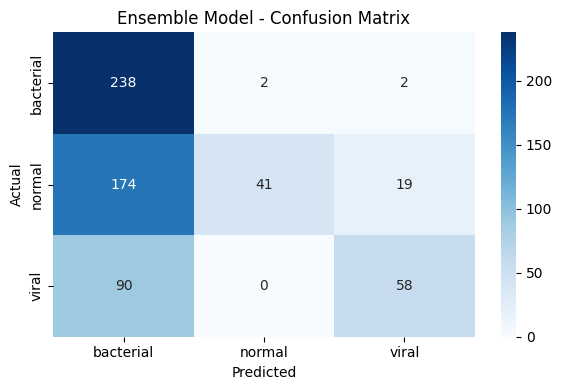

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best models
densenet_model = tf.keras.models.load_model('/content/DenseNet121_best_model.keras')
custom_cnn_model = tf.keras.models.load_model('/content/Custom CNN_best_model.keras')
mobilenet_model = tf.keras.models.load_model('/content/MobileNetV2_best_model.keras')
vgg16_model = tf.keras.models.load_model('/content/VGG16_best_model.keras')

# Make predictions on the test set
densenet_preds = densenet_model.predict(test_ds)
custom_cnn_preds = custom_cnn_model.predict(test_ds)
mobilenet_preds = mobilenet_model.predict(test_ds)
vgg16_preds = vgg16_model.predict(test_ds)

# Average the predictions
ensemble_preds = (densenet_preds + custom_cnn_preds + mobilenet_preds + vgg16_preds) / 4

# Get the predicted class for the ensemble
ensemble_predicted_labels = np.argmax(ensemble_preds, axis=1)

# Get the true labels for the test set
y_true = []
for _, y_batch in test_ds:
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))

# Evaluate the ensemble
print("\nEnsemble Model Evaluation:")
print("Classification Report:")
print(classification_report(y_true, ensemble_predicted_labels, target_names=class_names))

# Confusion Matrix for the ensemble
cm_ensemble = confusion_matrix(y_true, ensemble_predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Ensemble Model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# **Fine tune VGG16 model**

In [ ]:
# ----------------------------------------------------------------
# 4. VGG16 Model
# ----------------------------------------------------------------
def build_vgg16_model(num_classes):
    base = tf.keras.applications.VGG16(
        include_top=False, weights="imagenet",
        input_shape=INPUT_SHAPE, pooling="avg")
    # Unfreeze the base model for fine-tuning
    base.trainable = True
    # Unfreeze the last few layers (adjust as needed)
    for layer in base.layers[:-4]: # Unfreezing the last 4 layers
        layer.trainable = False

    inputs = layers.Input(shape=INPUT_SHAPE)
    x = base(inputs, training=True) # Set training to True for fine-tuning
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)


 Training VGG16...
Epoch 1/20
140/140 - 100s - 718ms/step - accuracy: 0.6062 - auc: 0.7994 - loss: 0.8469 - precision: 0.6609 - recall: 0.5069 - val_accuracy: 0.5825 - val_auc: 0.7801 - val_loss: 0.8732 - val_precision: 0.6872 - val_recall: 0.5102
Epoch 2/20
140/140 - 92s - 658ms/step - accuracy: 0.7025 - auc: 0.8643 - loss: 0.7130 - precision: 0.7399 - recall: 0.6454 - val_accuracy: 0.7437 - val_auc: 0.8854 - val_loss: 0.6385 - val_precision: 0.7775 - val_recall: 0.6916
Epoch 3/20
140/140 - 91s - 648ms/step - accuracy: 0.7332 - auc: 0.8891 - loss: 0.6379 - precision: 0.7583 - recall: 0.6866 - val_accuracy: 0.7563 - val_auc: 0.9054 - val_loss: 0.5847 - val_precision: 0.7860 - val_recall: 0.7272
Epoch 4/20
140/140 - 97s - 691ms/step - accuracy: 0.7534 - auc: 0.9071 - loss: 0.5732 - precision: 0.7757 - recall: 0.7211 - val_accuracy: 0.7665 - val_auc: 0.9073 - val_loss: 0.5745 - val_precision: 0.7899 - val_recall: 0.7348
Epoch 5/20
140/140 - 92s - 660ms/step - accuracy: 0.7583 - auc: 0.9

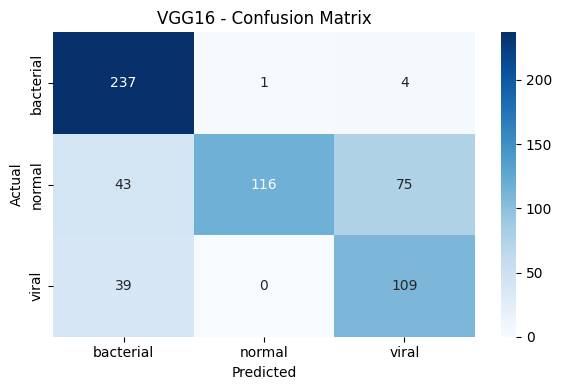

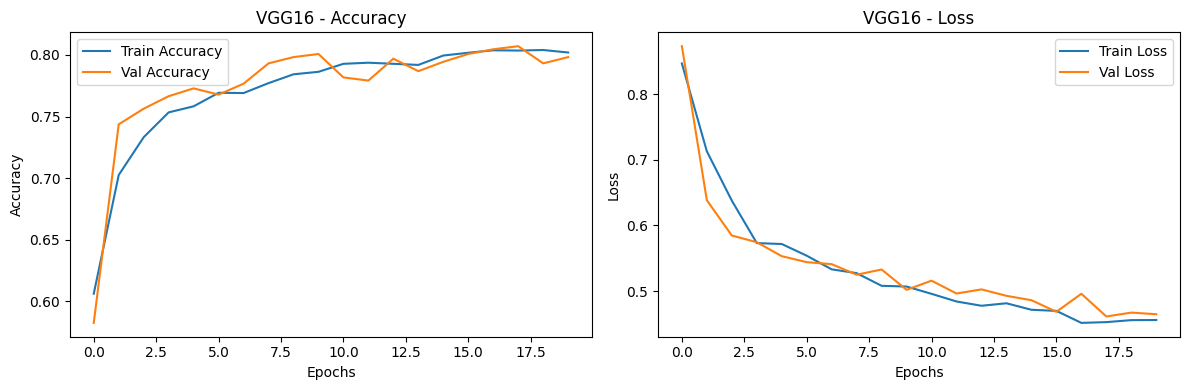

In [ ]:
# Compile and train
def compile_and_train(model, name, train_ds, val_ds, epochs=EPOCHS):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    print(f"\n Training {name}...")
    start_time = time.time()


    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f'{name}_best_model.keras', monitor='val_loss', save_best_only=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=2,
        callbacks=[model_checkpoint]

    )
    train_time = time.time() - start_time
    print(f" Training time for {name}: {train_time:.2f} seconds")
    return model, history, train_time

# Train and evaluate all models
models_to_train = {
    "VGG16": build_vgg16_model(NUM_CLASSES)
}

model_histories = {}

# Reduce epochs for initial testing
EPOCHS = 20

for model_name, model_instance in models_to_train.items():
    model, history, train_time = compile_and_train(model_instance, model_name, train_ds, val_ds, epochs=EPOCHS)

    # Evaluation
    print(f"\n Evaluating {model_name}...")
    start_test = time.time()
    y_true, y_pred = [], []

    # Use the trained model directly for evaluation
    # best_model = tf.keras.models.load_model(f'{model_name}_best_model.keras')


    for x_batch, y_batch in test_ds:
        preds = model.predict(x_batch)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(y_batch.numpy(), axis=1))

    test_time = time.time() - start_test
    print(f" Testing time: {test_time:.2f} seconds")

    print(" Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()